This notebook is for testing the output of the algorithm.

In [5]:
import sys
import os

# Pretend we're in the comfyui directory
comfyui_path = '../../../.'
comfyui_path = os.path.abspath(comfyui_path)
print(comfyui_path)
sys.path.insert(0, comfyui_path)

#
# Setup
#

# Init nodes
from nodes import init_custom_nodes
init_custom_nodes()
from nodes import (
    VAEDecode, VAEEncode,
    KSamplerAdvanced,
    EmptyLatentImage,
    SaveImage,
    CheckpointLoaderSimple,
    CLIPTextEncode,
)

# Paths
import folder_paths
folder_paths.add_model_folder_path("checkpoints", os.path.join(folder_paths.get_output_directory(), "checkpoints"))
folder_paths.add_model_folder_path("clip", os.path.join(folder_paths.get_output_directory(), "clip"))
folder_paths.add_model_folder_path("vae", os.path.join(folder_paths.get_output_directory(), "vae"))

from main import load_extra_path_config
load_extra_path_config(f"{comfyui_path}/extra_model_paths.yaml")

# Utils
from PIL import Image
import numpy as np
from IPython.display import display

def tensor_to_pil(img_tensor, batch_index=0):
    # Takes an image in a batch in the form of a tensor of shape [batch_size, channels, height, width]
    # and returns an PIL Image with the corresponding mode deduced by the number of channels

    # Take the image in the batch given by batch_index
    img_tensor = img_tensor[batch_index].unsqueeze(0)
    i = 255. * img_tensor.cpu().numpy()
    img = Image.fromarray(np.clip(i, 0, 255).astype(np.uint8).squeeze())
    return img

In [6]:
import torch
loader = CheckpointLoaderSimple()
checkpoint = folder_paths.get_filename_list("checkpoints")[0]
print(f"Using checkpoint {checkpoint}")
model, clip, vae = loader.load_checkpoint(checkpoint)

(empty_latent, ) = EmptyLatentImage().generate(width=512, height=512, batch_size=2)

(positive, ) = CLIPTextEncode().encode(
    text="beautiful scenery nature glass bottle landscape, , purple galaxy bottle,",
    clip=clip,
)

(negative, ) = CLIPTextEncode().encode(
    text="text, watermark", clip=clip
)

# seed = random.randint(1, 2 ** 64)
seed = 1

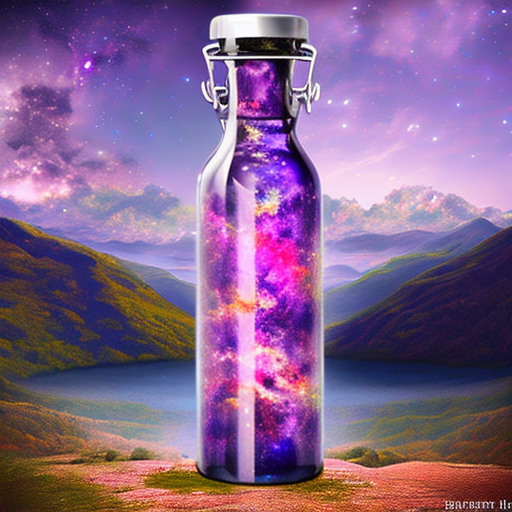

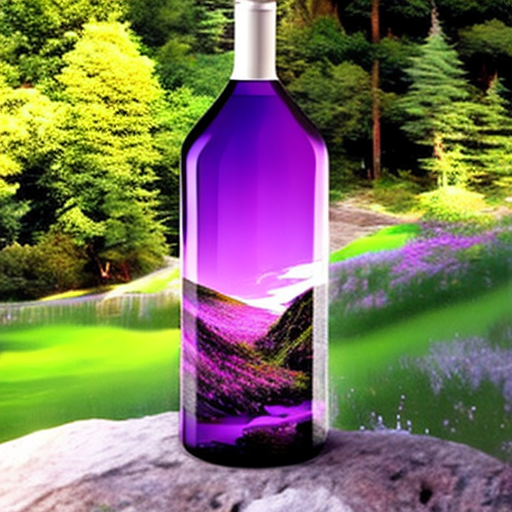

In [7]:
# Load images from file
liked = Image.open("liked.png")
disliked = Image.open("disliked.png")

# Convert to tensor
liked_tensor = torch.tensor(np.array(liked)).permute(2, 0, 1).float() / 255.
disliked_tensor = torch.tensor(np.array(disliked)).permute(2, 0, 1).float() / 255.

# Batch them
liked_tensor = liked_tensor.unsqueeze(0)
disliked_tensor = disliked_tensor.unsqueeze(0)
image = torch.cat([liked_tensor, disliked_tensor], dim=0).permute(0, 2, 3, 1)

im1, im2 = tensor_to_pil(image), tensor_to_pil(image, batch_index=1)
display(im1)
display(im2)

  0%|          | 0/10 [00:00<?, ?it/s]

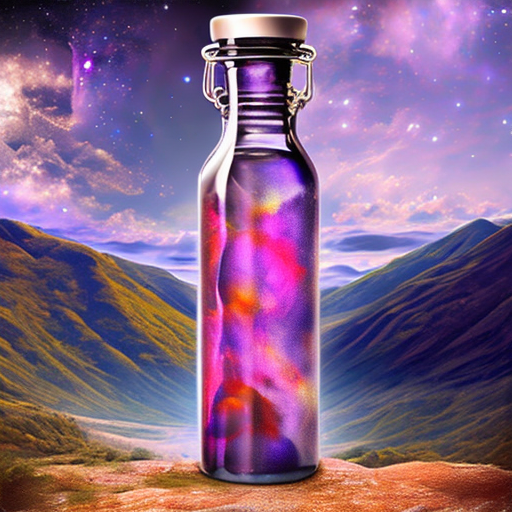

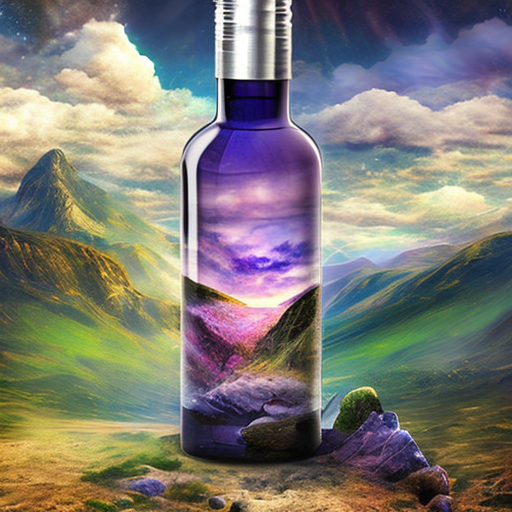

In [8]:
from nodes import (
    NODE_CLASS_MAPPINGS,
    VAEEncode, KSampler
)
KSamplerFABRIC = NODE_CLASS_MAPPINGS["KSamplerFABRIC"]
FABRICPatchModel = NODE_CLASS_MAPPINGS["FABRICPatchModel"]

with torch.inference_mode():
    (liked, ) = VAEEncode().encode(vae, image[0:1])
    (disliked, ) = VAEEncode().encode(vae, image[1:2])
    (samples, ) = KSamplerFABRIC().sample(
        model=model,
        positive=positive,
        negative=negative,
        latent_image=empty_latent,
        clip=clip,
        pos_latents=liked,
        neg_latents=None,
        seed=seed,
        steps=10,
        cfg=8,
        sampler_name="dpmpp_2m",
        scheduler="karras",
        denoise=1.0,
        pos_weight=.5,
        neg_weight=0.25,
        feedback_percent=0.5,
    )

    (image, ) = VAEDecode().decode(
        samples=samples, vae=vae
    )

    im1, im2 = tensor_to_pil(image), tensor_to_pil(image, batch_index=1)
    display(im1)
    display(im2)